In [1]:
from matplotlib import pyplot as plt
import yfinance as yf
import pandas as pd

# Download data

In [2]:
symbols = ['IEF', 'SPY', 'QQQ', 'EFA', 'EEM', 'TLT']

In [3]:
dfs = {}
for symbol in symbols:
    data = yf.Ticker(symbol)
    df = data.history(period='1d', start='1990-6-1', end='2020-6-01')
    
    dfs[symbol] = df
    print(symbol, "appended")

IEF appended
SPY appended
QQQ appended
EFA appended
EEM appended
TLT appended


# Preprocess data

In [4]:
# 시작 날짜 통일
start_dates = []
for symbol, df in dfs.items():
    start_dates.append(df.index[0])
start_date = max(start_dates)

for symbol, df in dfs.items():
    dfs[symbol] = df[df.index >= start_date]
    print(symbol, dfs[symbol].index[0])

IEF 2003-04-14 00:00:00
SPY 2003-04-14 00:00:00
QQQ 2003-04-14 00:00:00
EFA 2003-04-14 00:00:00
EEM 2003-04-14 00:00:00
TLT 2003-04-14 00:00:00


In [5]:
# 월별 데이터로 변환

In [6]:
timestamp_to_month = lambda x: x.strftime('%Y-%m')
f = {'High':'max', 'Low':'min', 'Open':'first', 'Close':'last', 'Volume':'sum'}

In [7]:
for symbol, df in dfs.items():
    df = df.groupby(df.index.map(timestamp_to_month)).agg(f)
    dfs[symbol] = df
    print(symbol, "converted")

IEF converted
SPY converted
QQQ converted
EFA converted
EEM converted
TLT converted


In [8]:
dfs['IEF']

,High,Low,Open,Close,Volume
Date,,,,,
2003-04,51.33,50.34,50.78,51.32,926100
2003-05,53.38,51.00,51.43,53.26,2707000
2003-06,54.30,52.56,53.04,52.89,2906500
2003-07,53.36,49.83,53.16,50.24,4484300
2003-08,51.51,49.93,50.27,50.60,3849200
...,...,...,...,...,...
2020-01,113.46,109.99,110.05,113.38,72902700
2020-02,116.93,112.06,113.11,116.74,111552100
2020-03,123.01,114.03,117.17,121.09,212863200


# Backtesting

In [31]:
df_account = pd.DataFrame(index=dfs['IEF'].index).reset_index()

In [32]:
# 3개월 수익률을 월마다 구하기

In [33]:
for symbol in symbols:
    df_account[symbol] = 0.0

In [34]:
for i in range (len(df_account)):
    if i < 3:
        continue
    
    for symbol in symbols:
        now = dfs[symbol].iloc[i].Open
        past = dfs[symbol].iloc[i-3].Open
        #df_account.ix[i, symbol] = (now - past) / past # 3개월 수익률 확인
        df_account.at[i, symbol] = now / past # 3개월 수익률 확인

In [35]:
def get_symbol(x):
    max_yield = -1.0
    for symbol in symbols:
        if symbol == 'IEF':
            continue
        
        if x[symbol] < 1.0: # 5개 EFT 중 하나라도 수익률이 마이너스이면 IEF로 선택
            return 'IEF' 
        else:
            if x[symbol] > max_yield:
                max_symbol = symbol
                max_yield = x[symbol]
    return max_symbol

In [36]:
df_account['SYMBOL'] = df_account.apply(lambda x: get_symbol(x), axis=1)

In [37]:
df_account

,Date,IEF,SPY,QQQ,EFA,EEM,TLT,SYMBOL
0,2003-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,IEF
1,2003-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,IEF
2,2003-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,IEF
3,2003-07,1.046869,1.115725,1.160107,1.140538,1.199755,1.072297,EEM
4,2003-08,0.977445,1.083014,1.154777,1.098896,1.208187,0.932017,IEF
...,...,...,...,...,...,...,...,...
201,2020-01,0.993949,1.092000,1.133817,1.088013,1.132881,0.973269,IEF
202,2020-02,1.016993,1.065661,1.114624,1.008464,1.003342,1.035114,QQQ
203,2020-03,1.064408,0.952591,1.020614,0.924096,0.972797,1.129546,IEF
204,2020-04,1.107497,0.770953,0.863653,0.739490,0.729712,1.237390,IEF


In [38]:
len(df_account[df_account.SYMBOL == 'IEF']) / len(df_account)

0.7038834951456311

In [39]:
def get_multiple(x):
    symbol = x.SYMBOL
    open_price = dfs[symbol].loc[x['Date'], 'Open']
    close_price = dfs[symbol].loc[x['Date'], 'Close']
    return close_price / open_price

In [40]:
df_account['MUL'] = df_account.apply(lambda x: get_multiple(x), axis=1)

In [41]:
df_account

,Date,IEF,SPY,QQQ,EFA,EEM,TLT,SYMBOL,MUL
0,2003-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,IEF,1.010634
1,2003-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,IEF,1.035582
2,2003-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,IEF,0.997172
3,2003-07,1.046869,1.115725,1.160107,1.140538,1.199755,1.072297,EEM,1.053115
4,2003-08,0.977445,1.083014,1.154777,1.098896,1.208187,0.932017,IEF,1.006565
...,...,...,...,...,...,...,...,...,...
201,2020-01,0.993949,1.092000,1.133817,1.088013,1.132881,0.973269,IEF,1.030259
202,2020-02,1.016993,1.065661,1.114624,1.008464,1.003342,1.035114,QQQ,0.934857
203,2020-03,1.064408,0.952591,1.020614,0.924096,0.972797,1.129546,IEF,1.033456
204,2020-04,1.107497,0.770953,0.863653,0.739490,0.729712,1.237390,IEF,0.996226


In [42]:
df_account = df_account[3:].reset_index()

In [43]:
df_account

,index,Date,IEF,SPY,QQQ,EFA,EEM,TLT,SYMBOL,MUL
0,3,2003-07,1.046869,1.115725,1.160107,1.140538,1.199755,1.072297,EEM,1.053115
1,4,2003-08,0.977445,1.083014,1.154777,1.098896,1.208187,0.932017,IEF,1.006565
2,5,2003-09,0.952866,1.045907,1.113437,1.062668,1.195953,0.902369,IEF,1.050851
3,6,2003-10,1.003950,1.034766,1.097918,1.093416,1.145046,0.962087,IEF,0.980513
4,7,2003-11,1.037796,1.070146,1.118136,1.148100,1.188771,1.043241,EEM,1.001629
...,...,...,...,...,...,...,...,...,...,...
198,201,2020-01,0.993949,1.092000,1.133817,1.088013,1.132881,0.973269,IEF,1.030259
199,202,2020-02,1.016993,1.065661,1.114624,1.008464,1.003342,1.035114,QQQ,0.934857
200,203,2020-03,1.064408,0.952591,1.020614,0.924096,0.972797,1.129546,IEF,1.033456
201,204,2020-04,1.107497,0.770953,0.863653,0.739490,0.729712,1.237390,IEF,0.996226


In [44]:
df_account['SWITCH_MUL'] = 0.0

In [45]:
df_account

,index,Date,IEF,SPY,QQQ,EFA,EEM,TLT,SYMBOL,MUL,SWITCH_MUL
0,3,2003-07,1.046869,1.115725,1.160107,1.140538,1.199755,1.072297,EEM,1.053115,0.0
1,4,2003-08,0.977445,1.083014,1.154777,1.098896,1.208187,0.932017,IEF,1.006565,0.0
2,5,2003-09,0.952866,1.045907,1.113437,1.062668,1.195953,0.902369,IEF,1.050851,0.0
3,6,2003-10,1.003950,1.034766,1.097918,1.093416,1.145046,0.962087,IEF,0.980513,0.0
4,7,2003-11,1.037796,1.070146,1.118136,1.148100,1.188771,1.043241,EEM,1.001629,0.0
...,...,...,...,...,...,...,...,...,...,...,...
198,201,2020-01,0.993949,1.092000,1.133817,1.088013,1.132881,0.973269,IEF,1.030259,0.0
199,202,2020-02,1.016993,1.065661,1.114624,1.008464,1.003342,1.035114,QQQ,0.934857,0.0
200,203,2020-03,1.064408,0.952591,1.020614,0.924096,0.972797,1.129546,IEF,1.033456,0.0
201,204,2020-04,1.107497,0.770953,0.863653,0.739490,0.729712,1.237390,IEF,0.996226,0.0


In [88]:
# switching cost
SWITCH_COST = 0.999
for i in range(len(df_account)):
    if i == 0:
        continue
    
    prev_symbol = df_account.iloc[i-1]['SYMBOL']
    cur_symbol = df_account.iloc[i]['SYMBOL']
    
    if prev_symbol != cur_symbol:
        df_account.at[i, 'SWITCH_MUL'] = df_account.iloc[i]['MUL'] * SWITCH_COST
    else:
        df_account.at[i, 'SWITCH_MUL'] = df_account.iloc[i]['MUL']

In [89]:
df_account.head()

,index,Date,IEF,SPY,QQQ,EFA,EEM,TLT,SYMBOL,MUL,SWITCH_MUL,CUMPROD,PREV_CUMPROD,MDD
0,3,2003-07,1.046869,1.115725,1.160107,1.140538,1.199755,1.072297,EEM,1.053115,1.000000,1.000000,NaN,1.000000
1,4,2003-08,0.977445,1.083014,1.154777,1.098896,1.208187,0.932017,IEF,1.006565,1.005558,1.004551,1.000000,1.003545
2,5,2003-09,0.952866,1.045907,1.113437,1.062668,1.195953,0.902369,IEF,1.050851,1.050851,1.055634,1.003545,1.050851
3,6,2003-10,1.003950,1.034766,1.097918,1.093416,1.145046,0.962087,IEF,0.980513,0.980513,1.035063,1.054576,0.980513
4,7,2003-11,1.037796,1.070146,1.118136,1.148100,1.188771,1.043241,EEM,1.001629,1.000627,1.034675,1.034026,0.998624


In [90]:
df_account['CUMPROD'] = df_account['SWITCH_MUL'].cumprod()

In [91]:
df_account

,index,Date,IEF,SPY,QQQ,EFA,EEM,TLT,SYMBOL,MUL,SWITCH_MUL,CUMPROD,PREV_CUMPROD,MDD
0,3,2003-07,1.046869,1.115725,1.160107,1.140538,1.199755,1.072297,EEM,1.053115,1.000000,1.000000,NaN,1.000000
1,4,2003-08,0.977445,1.083014,1.154777,1.098896,1.208187,0.932017,IEF,1.006565,1.005558,1.005558,1.000000,1.003545
2,5,2003-09,0.952866,1.045907,1.113437,1.062668,1.195953,0.902369,IEF,1.050851,1.050851,1.056691,1.003545,1.050851
3,6,2003-10,1.003950,1.034766,1.097918,1.093416,1.145046,0.962087,IEF,0.980513,0.980513,1.036100,1.054576,0.980513
4,7,2003-11,1.037796,1.070146,1.118136,1.148100,1.188771,1.043241,EEM,1.001629,1.000627,1.036750,1.034026,0.998624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,201,2020-01,0.993949,1.092000,1.133817,1.088013,1.132881,0.973269,IEF,1.030259,1.030259,5.404541,4.577517,1.030259
199,202,2020-02,1.016993,1.065661,1.114624,1.008464,1.003342,1.035114,QQQ,0.934857,0.933922,5.047420,4.716028,0.932052
200,203,2020-03,1.064408,0.952591,1.020614,0.924096,0.972797,1.129546,IEF,1.033456,1.032422,5.211069,4.395585,1.030355
201,204,2020-04,1.107497,0.770953,0.863653,0.739490,0.729712,1.237390,IEF,0.996226,0.996226,5.191401,4.529014,0.996226


In [92]:
pow(df_account['CUMPROD'].tolist()[-1],(1.0/17.0))

1.1018108340745816

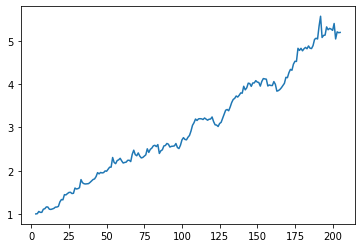

In [93]:
plt.plot(df_account['index'], df_account['CUMPROD'])
plt.show()

In [94]:
df_account['PREV_CUMPROD'] = df_account['CUMPROD'].shift(1)

In [95]:
df_account['MDD'] = df_account['CUMPROD'] / df_account['PREV_CUMPROD']

In [96]:
df_account['MDD'] = df_account['MDD'].fillna(1.0)

In [97]:
min(df_account['MDD'])

0.9117678156058363